In [8]:
import pandas as pd
import numpy as np
from scipy import stats

 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
import xgboost as xgb
import sklearn.metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from mpl_toolkits.basemap import Basemap
import hazelbean as hb

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_columns', 500)



# Input data 

In [9]:
baseline_regression_data_path = '../ipbes_invest_crop_yield_project/intermediate/create_baseline_regression_data/baseline_regression_data.csv'
country_ids_raster_path = '../ipbes_invest_crop_yield_project/input/Cartographic/country_ids.tif'

df_land = pd.read_csv(baseline_regression_data_path)

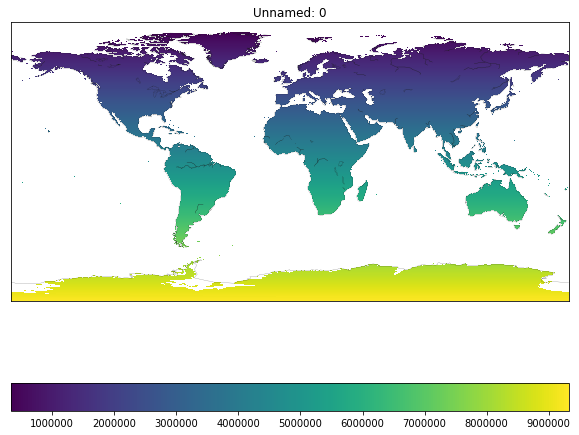

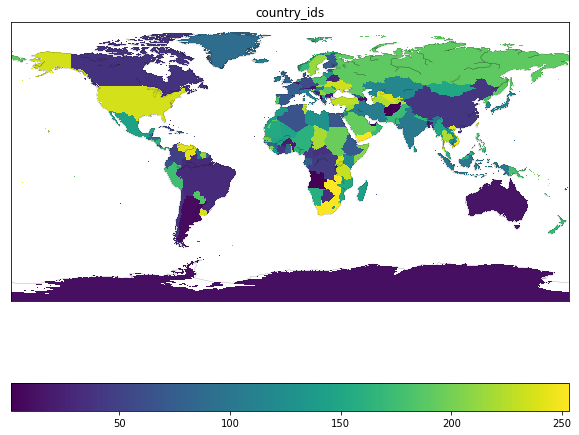

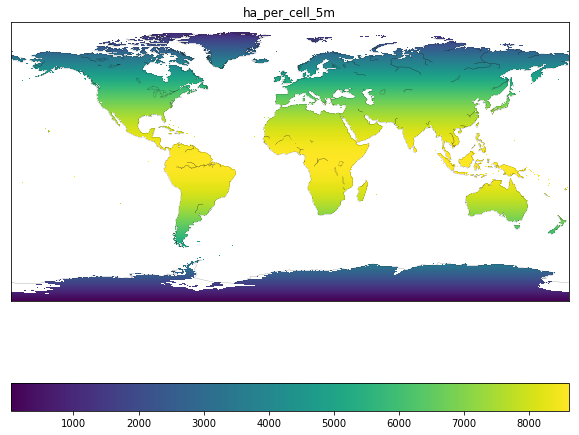

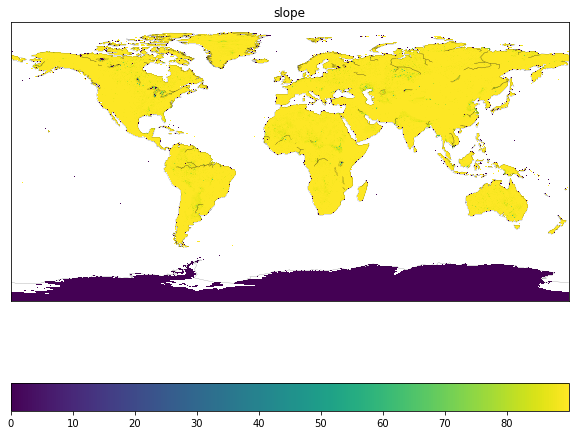

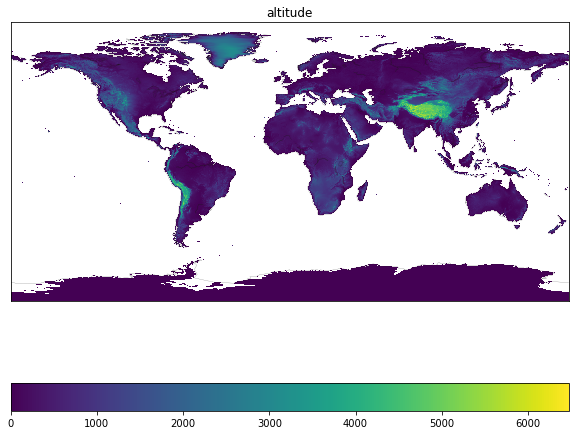

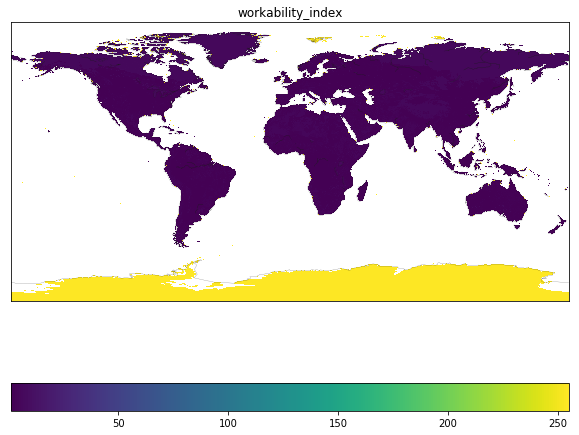

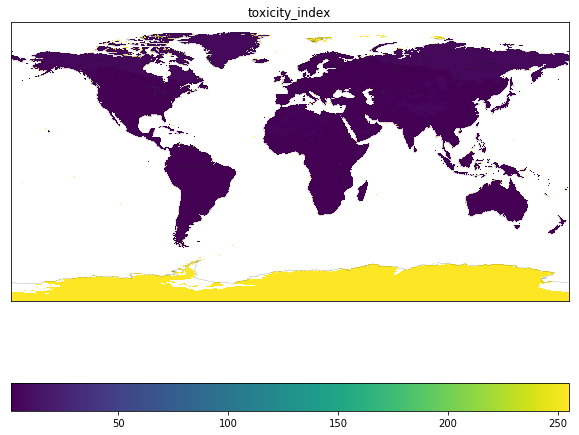

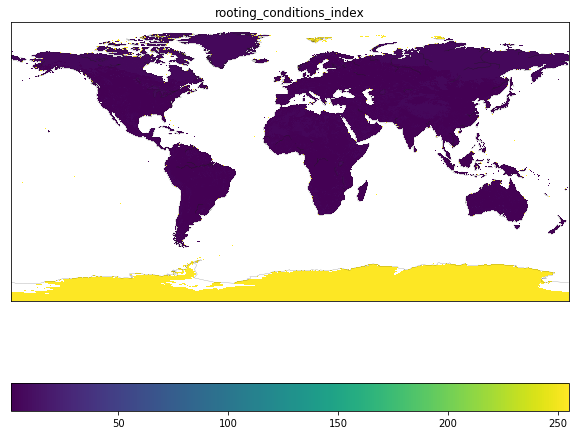

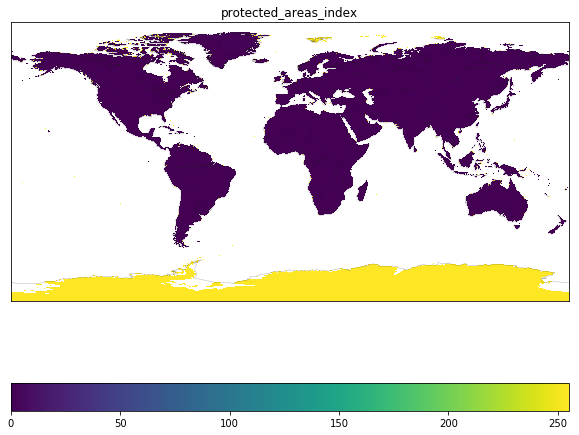

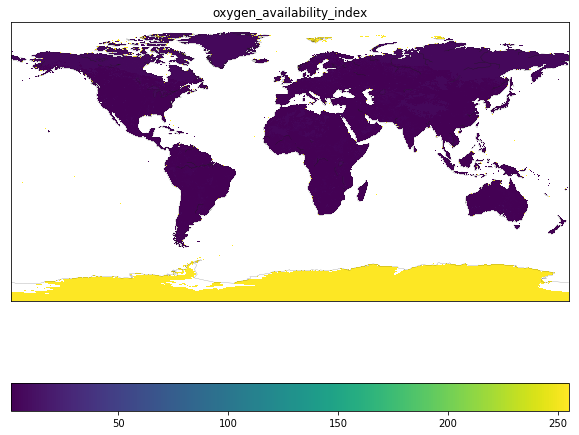

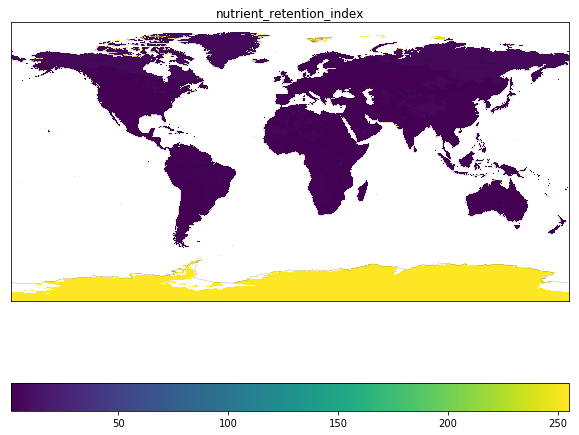

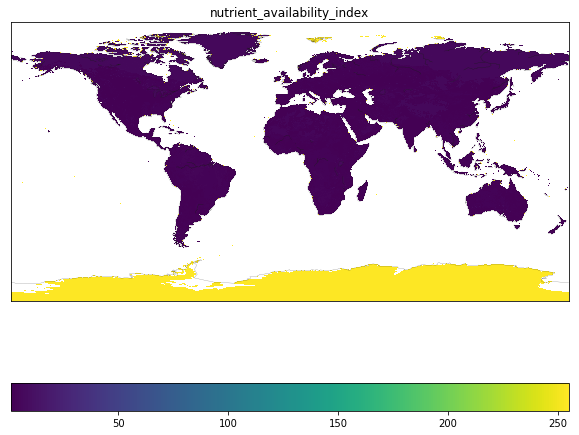

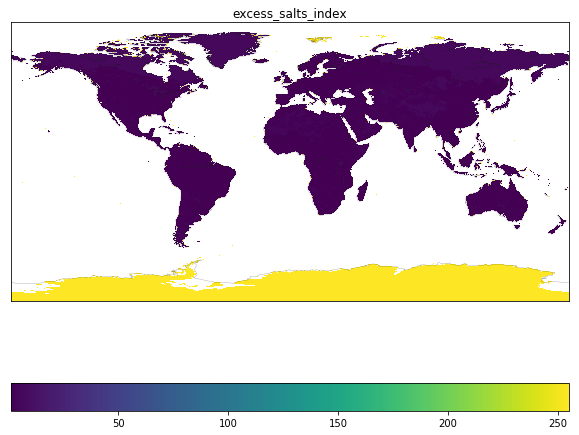

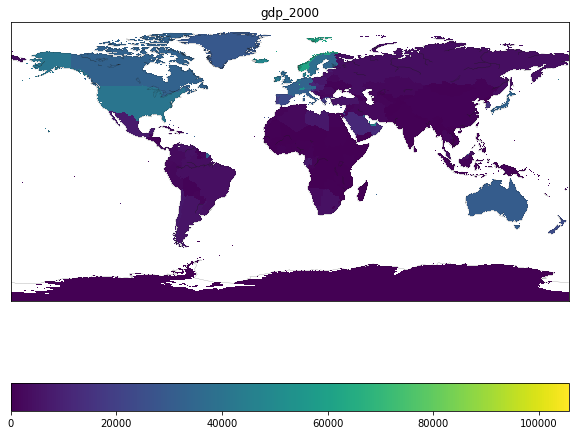

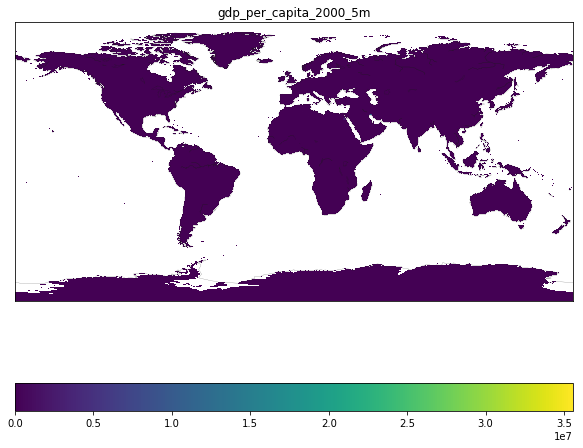

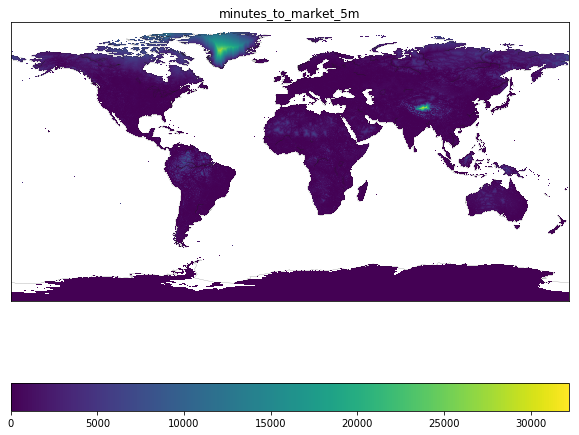

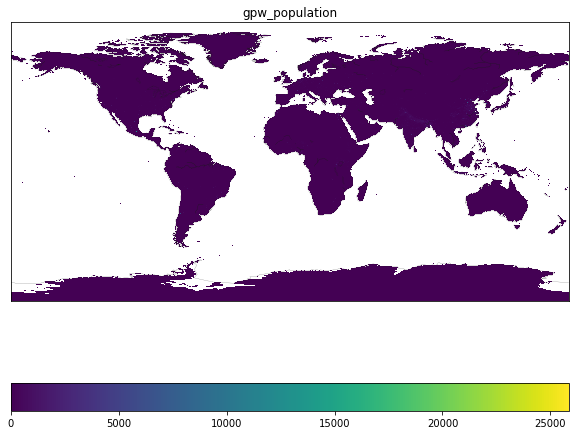

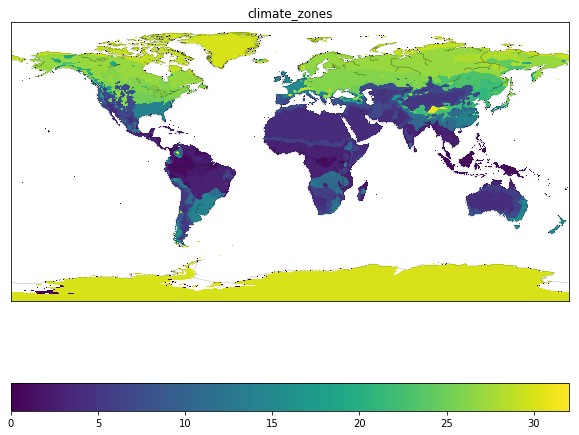

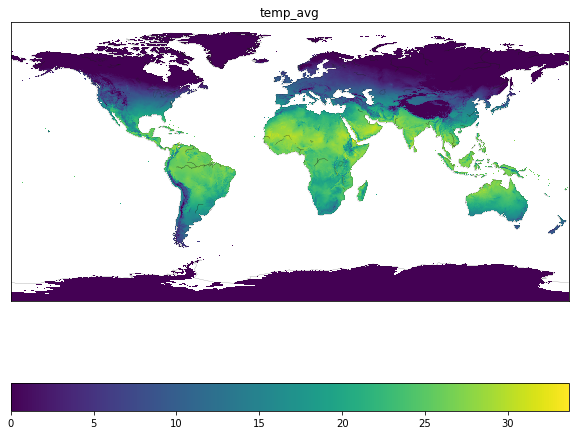

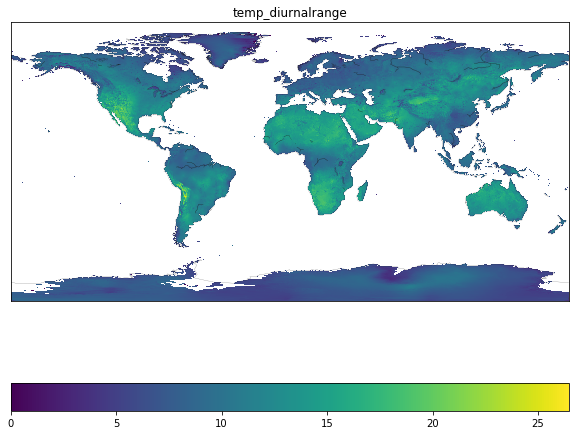

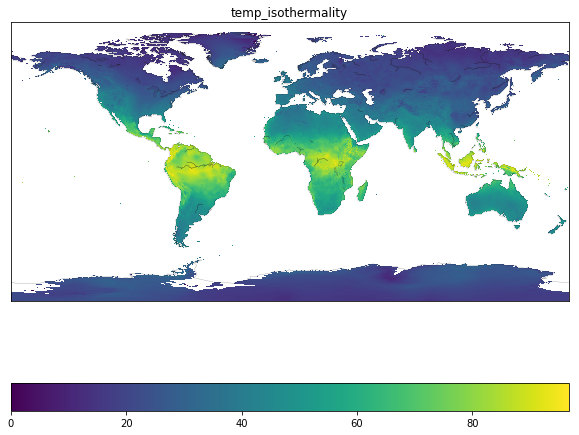

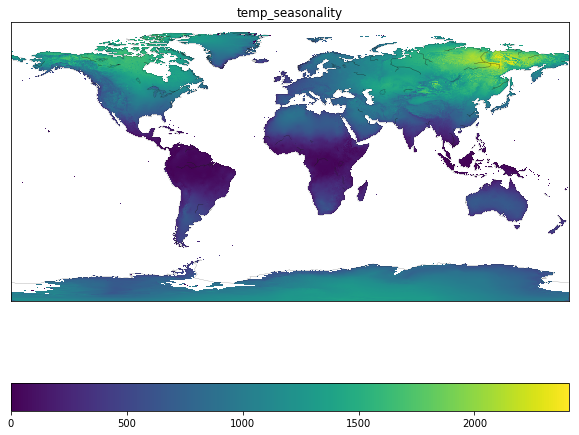

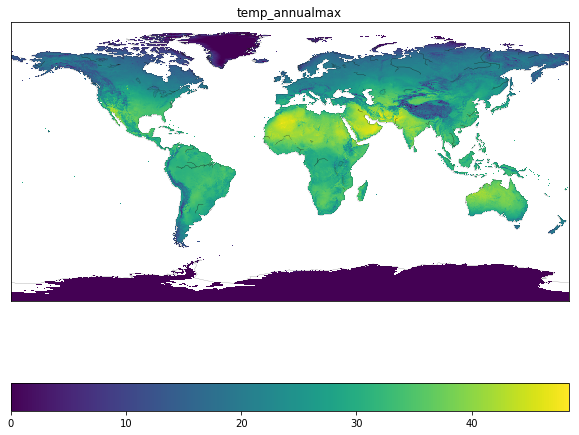

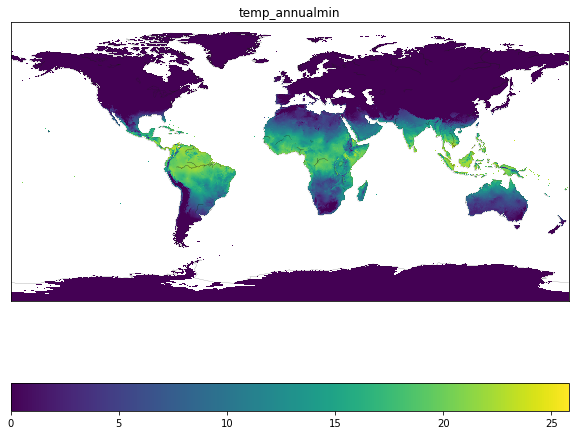

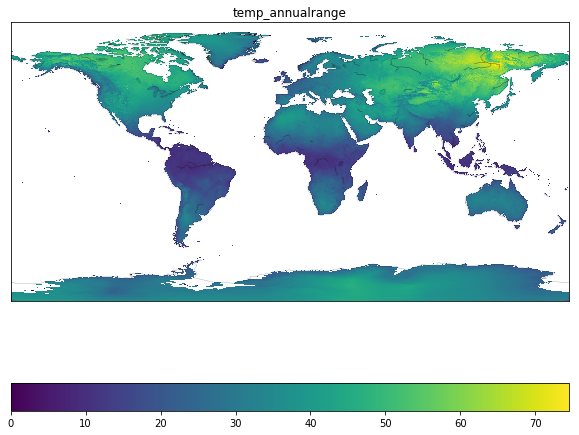

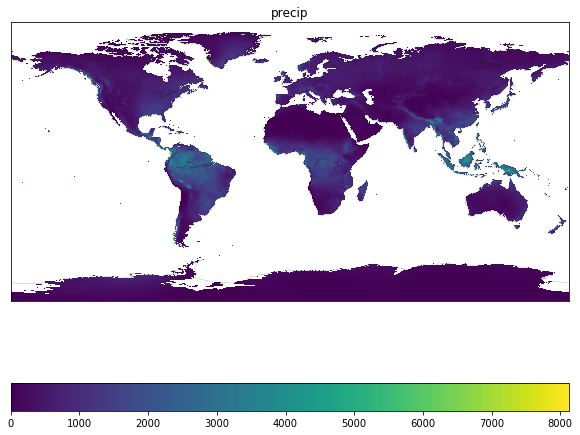

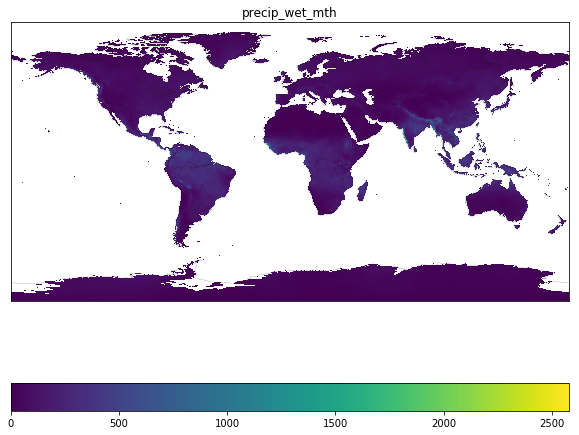

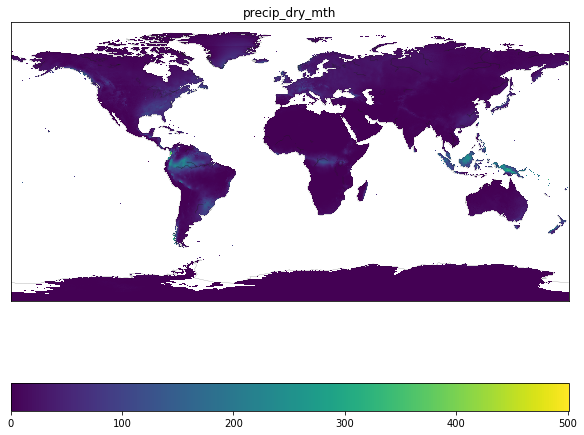

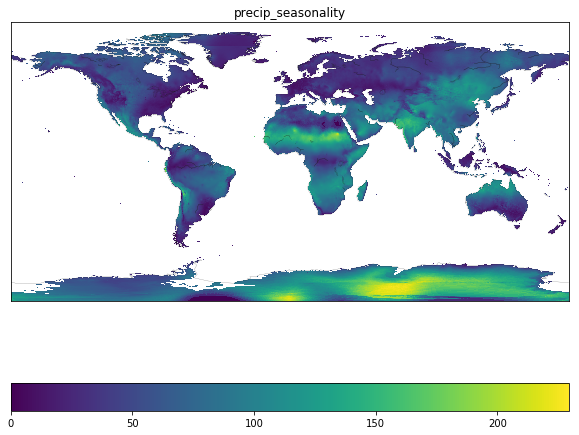

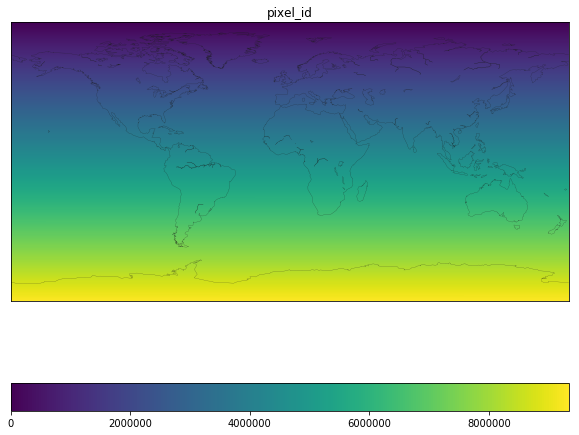

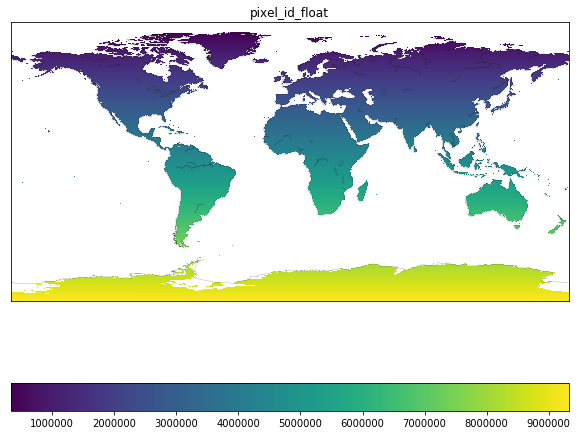

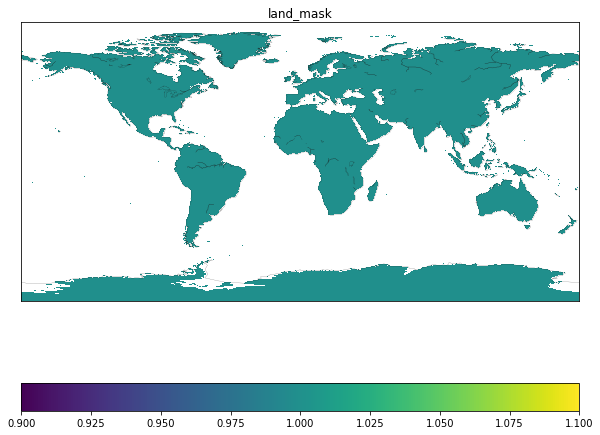

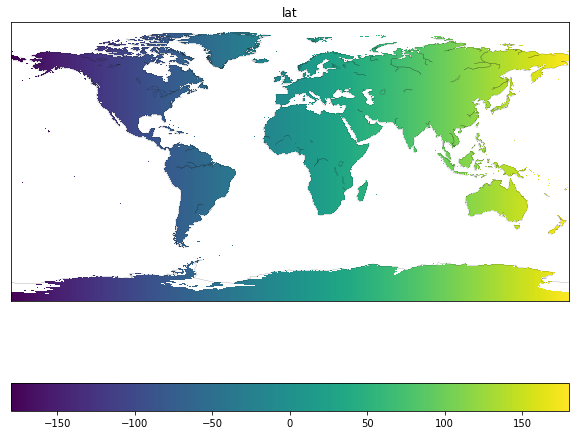

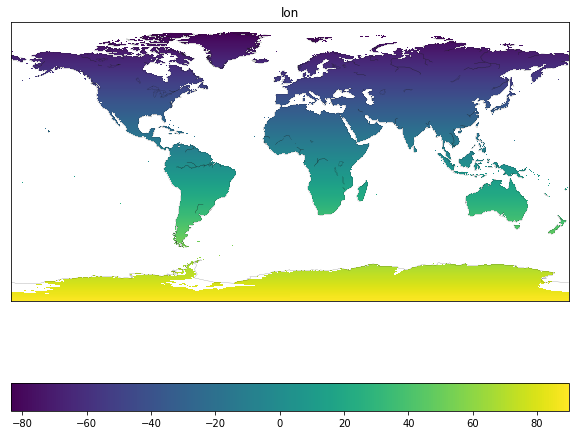

In [49]:
for col in df_land.columns:
    fig,axes = plt.subplots(1, 1, figsize=(10,10))
    visualize_data(col)
    plt.show()
    
    

In [10]:
def load_data(subset=True):

    crop_types_df = pd.read_csv('../ipbes_invest_crop_yield_project/intermediate/aggregate_crops_by_type/aggregated_crop_data.csv')

    df = crop_types_df.merge(df_land,how='outer',on='pixel_id')


    if subset==True:
        df = df.sample(frac=0.02, replace=False, weights=None, random_state=None, axis=0)

    elif subset==False: #Save validation data
        x = df.drop(['calories_per_ha'], axis=1)
        y = df['calories_per_ha']
        X, X_validation, Y, y_validation = train_test_split(x, y)
        df = X.merge(Y,how='outer',left_index=True,right_index=True)

    #Remove cal_per_ha per crop type for now
    df = df.drop(labels=['c3_annual_calories_per_ha', 'c3_perennial_calories_per_ha',
           'c4_annual_calories_per_ha', 'c4_perennial_calories_per_ha',
           'nitrogen_fixer_calories_per_ha'], axis=1)

    #Remove helper columns (not features)
    df = df.drop(labels=['Unnamed: 0', 'country_ids',
           'ha_per_cell_5m'], axis=1)

    # Rename cols
    df = df.rename(columns={'bio12': 'precip', 'bio1': 'temperature',
                                'minutes_to_market_5m': 'min_to_market',
                                'gdp_per_capita_2000_5m': 'gdp_per_capita',
                                'gdp_2000': 'gdp'})
    # Encode properly NaNs
    df['slope'] = df['slope'].replace({0: np.nan})  # 143 NaN in 'slope' variable
    for soil_var in ['workability_index', 'toxicity_index', 'rooting_conditions_index', 'oxygen_availability_index',
                     'nutrient_retention_index', 'nutrient_availability_index', 'excess_salts_index']:
        df[soil_var] = df[soil_var].replace({255: np.nan})
        
    # Drop NaN
    df = df.dropna()
    df = df[df['calories_per_ha'] != 0]    
    
    #Encode climate zones (as str)
    climate_zones_map = {1:'Af',2:'Am',3:'Aw',
                     5:'BWk',4:'BWh',7:'BSk',6:'BSh',
                     14:'Cfa',15:'Cfb',16:'Cfc',8:'Csa',
                     9:'Csb',10:'Csc',11:'Cwa',12:'Cwb',13:'Cwc',
                     25:'Dfa',26:'Dfb',27:'Dfc',28:'Dfd',17:'Dsa',18:'Dsb',19:'Dsc',
                     20:'Dsd',21:'Dwa',22:'Dwb',23:'Dwc',24:'Dwd',
                     30:'EF',29:'ET'}
    df['climate_zones'] = df['climate_zones'].map(climate_zones_map)
    
    # Encode climate zones as dummies
    climate_dummies_df = pd.get_dummies(df['climate_zones'])
    for col in climate_dummies_df.columns:
        climate_dummies_df = climate_dummies_df.rename({col:str('climatezone_'+col)},axis=1)
    
    df = df.merge(climate_dummies_df, right_index=True,left_index=True)
    df = df.drop('climate_zones',axis=1)
    
    # Log some skewed variables
    df['calories_per_ha'] = df['calories_per_ha'].apply(lambda x: np.log(x) if x != 0 else 0)

    for col in ['gdp_per_capita','altitude', 'min_to_market', 'gpw_population']:
        df[str('log_'+col)] = df[col].apply(lambda x: np.log(x) if x != 0 else 0)


    # Encode properly NaNs
    df['slope'] = df['slope'].replace({0: np.nan})  # 143 NaN in 'slope' variable
    for soil_var in ['workability_index', 'toxicity_index', 'rooting_conditions_index', 'oxygen_availability_index',
                     'nutrient_retention_index', 'nutrient_availability_index', 'excess_salts_index']:
        df[soil_var] = df[soil_var].replace({255: np.nan})
            
    df = df.set_index('pixel_id')

    return df

In [11]:
df = load_data()

In [12]:
columns_without_climatezones = df.columns
for col in df.columns:
    if "climatezone" in col: 
        columns_without_climatezones = columns_without_climatezones.drop([col])
        
        

# Evaluation Metrics

In [ ]:
results = pd.DataFrame(columns=['Model','num_features','Features','MSE','R2'])

#### Q: What is a statistically significant R2 in our case ?
"*A model was judged significant if it explained more than 14% of variance in yield or production (R2 > 0.14). This threshold
was based on the 95th percentile of the R2 statistic from a Monte Carlo experiment, which computed 1000 multiple regression
models for a randomly generated 42-year time series with two random predictor variables." (Lobell, 2008)

#### Alice: Null hypthesis test by permutations
Mélanger les y et essayer de les prédire. x1000 -- so the datasets have the same distribution. --> then chi-test ou student test sur les R2

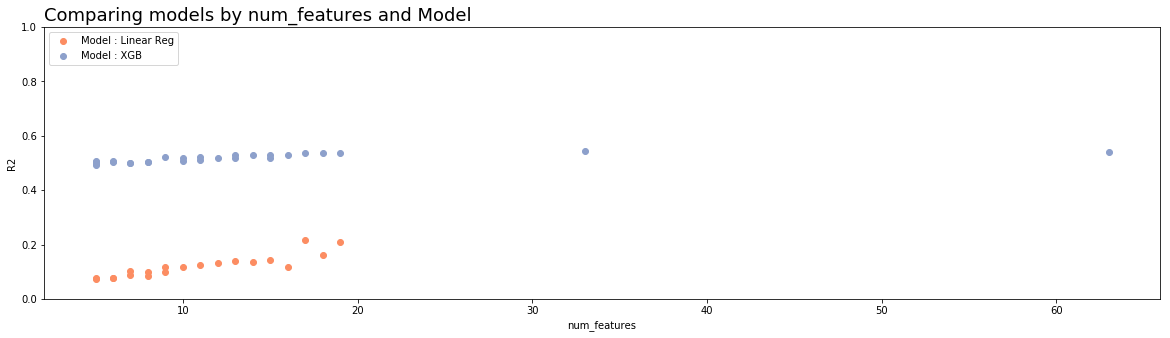

In [8]:
results_linear_1 =  pd.read_csv('../ipbes_invest_crop_yield_project/intermediate/create_results_table/results_linear_1.csv')
results_xgb_0    =  pd.read_csv('../ipbes_invest_crop_yield_project/intermediate/create_results_table/Results_xgbAug8.csv')
results_xgb_1    =  pd.read_csv('../ipbes_invest_crop_yield_project/intermediate/create_results_table/Results_xgbAug9.csv')
                 
results_all = pd.concat([results_linear_1,results_xgb_1])                 
                 
plot_R2_2params('num_features','Model',results_all, scatter=True,ylim=(0,1))

### Alice : show std on this plot
### Is xgb determinist? Sinon faire 100x

In [6]:
results_linear_1 =  pd.read_csv('../ipbes_invest_crop_yield_project/intermediate/create_results_table/results_linear_1.csv')
results_xgb_0    =  pd.read_csv('../ipbes_invest_crop_yield_project/intermediate/create_results_table/Results_xgbAug8.csv')
results_xgb_1    =  pd.read_csv('../ipbes_invest_crop_yield_project/intermediate/create_results_table/Results_xgbAug9.csv')
                 
results_all = pd.concat([results_linear_1,results_xgb_1])                 
                 
plot_R2_2params('num_features','Model',results_all, scatter=True,ylim=(0.49,56))

### Alice : show std on this plot
### Is xgb determinist? Sinon faire 100x

NameError: name 'plot_R2_2params' is not defined

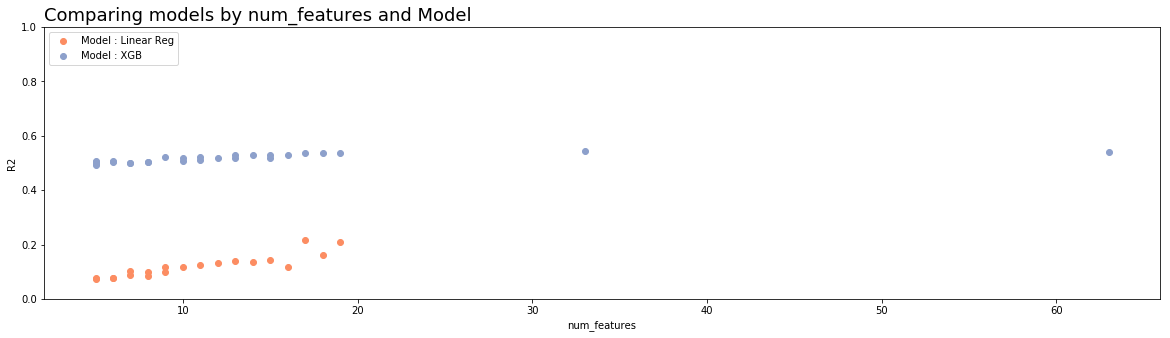

In [8]:
results_linear_1 =  pd.read_csv('../ipbes_invest_crop_yield_project/intermediate/create_results_table/results_linear_1.csv')
results_xgb_0    =  pd.read_csv('../ipbes_invest_crop_yield_project/intermediate/create_results_table/Results_xgbAug8.csv')
results_xgb_1    =  pd.read_csv('../ipbes_invest_crop_yield_project/intermediate/create_results_table/Results_xgbAug9.csv')
                 
results_all = pd.concat([results_linear_1,results_xgb_1])                 
                 
plot_R2_2params('num_features','Model',results_all, scatter=True,ylim=(0,1))

# Modeling approaches (1) : Linear regression

In [ ]:
### - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
### - - - - - - - - - - - - - - - -  Linear regression - - - - - - - - - - - - - - - - 
### - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


regression = LinearRegression()

model = 'Linear Reg'

dataframe = df
        

# Iterate over ≠ numbers of features
for num_features in range (5,20):

    ## RFE - Features selection
    selector = RFE(regression, num_features, step=1)

    x = dataframe.drop(['calories_per_ha'], axis=1) ## TODO climate_zones encode One Hot Encoder
    y = dataframe['calories_per_ha']
    X, X_test, Y, Y_test = train_test_split(x, y)

    X_RFE = selector.fit_transform(X,Y)

    features_selected = [X.columns[feature_pos] for feature_pos in selector.get_support(indices=True)]
    features_selected.append('calories_per_ha')
    scores = do_regression(regression,dataframe[features_selected])
    R2_score = scores[0]
    MSE_score = scores[1]
    MAE_score = scores[2]

    results = results.append({'Model': model,
                              'num_features':num_features,
                              'Features':features_selected,
                              'R2':R2_score,
                              'MSE':MSE_score},
                             ignore_index=True)
    

# Modeling approaches (2) : Polynomial regression

In [ ]:
### - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
### - - - - - - - - - - - - - - - -  Polynomial regression - - - - - - - - - - - - - - - - 
### - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -



regression = LinearRegression()

for interaction_terms in [False,True]:
    for degree in [2,3]:
        
        print('Running Polynomial of degree ' + str(degree)+ interaction_terms*(' with interaction terms'))
        
        
        model = str('Poly deg'+str(degree)+interaction_terms*' w/ interact')

        dataframe = make_polynomial(df)

        

        # Iterate over ≠ numbers of features
        for num_features in range (5,10):
            
            print('  Doing regression with '+str(num_features)+ ' features ...')

            ## RFE - Features selection
            selector = RFE(regression, num_features, step=1)

            x = dataframe.drop(['calories_per_ha'], axis=1) 
            y = dataframe['calories_per_ha']
            X, X_test, Y, Y_test = train_test_split(x, y)

            X_RFE = selector.fit_transform(X,Y)

            features_selected = [X.columns[feature_pos] for feature_pos in selector.get_support(indices=True)]
            features_selected.append('calories_per_ha')
            scores = do_regression(regression,dataframe[features_selected])
            R2_score = scores[0]
            MSE_score = scores[1]
            MAE_score = scores[2]

            results = results.append({'Model': model,
                                      'num_features':num_features,
                                      'Features':features_selected,
                                      'R2':R2_score,
                                      'MSE':MSE_score},
                                     ignore_index=True)
            
            print('  ... done')
    

# Modeling approaches (3) : Tree based models

In [ ]:
### - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
### - - - - - - - - - - - - - - - - -  XGB - - - - - - - - - - - - - - - - - - - - - - - 
### - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

model = 'XGB'


regression = xgb.XGBRegressor()

print('Running XGBoost')

# Iterate over ≠ numbers of features
for num_features in range (5,6):
    
    print('    with '+str(num_features)+ ' features ...')
    
    ## RFE - Features selection
    selector = RFE(regression, num_features, step=1)

    x = df.drop(['calories_per_ha','climate_zones'], axis=1) ## TODO climate_zones encode One Hot Encoder
    y = df['calories_per_ha']
    X, X_test, Y, Y_test = train_test_split(x, y)

    X_RFE = selector.fit_transform(X,Y)

    features_selected = [X.columns[feature_pos] for feature_pos in selector.get_support(indices=True)]
    features_selected.append('calories_per_ha')
    scores = do_regression(regression,df[features_selected])
    R2_score = scores[0]
    MSE_score = scores[1]
    MAE_score = scores[2]
    
    results = results.append({'Model': model,
                              'num_features':num_features,
                              'Features':features_selected,
                              'R2':R2_score,
                              'MSE':MSE_score},
                             ignore_index=True)
    
    
    print('    ... done')

### Tuning with Grid Search

In [ ]:
xgb_regressor = xgb.XGBRegressor()

parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [.03, .07, .2], #so called `eta` value
              'max_depth': [3, 5, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.5,0.75,1],
              'colsample_bytree': [0.5,0.75,1],
              'n_estimators': [300,500,600]}

parameters2 = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [.01,.03, .05,.07], #so called `eta` value
              'max_depth': [5,6,7,8],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.5,0.75,1],
              'colsample_bytree': [0.65,0.75,0.85],
              'n_estimators': [300,500,600,700]}

xgb_grid = GridSearchCV(xgb_regressor,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

x = df.drop(['calories_per_ha'], axis=1)
y = df['calories_per_ha']

X_train, X_test, y_train, y_test = train_test_split(x, y)
xgb_grid.fit(X_train,
         y_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

In [ ]:
# Results from cell above
# Fitting 2 folds for each of 243 candidates, totalling 486 fits | elapsed: 16.0min finished
best_R2 = 0.44336470168217684
best_parameters = {'colsample_bytree': 0.75, 'learning_rate': 0.03, 'max_depth': 7,
                   'min_child_weight': 4, 'n_estimators': 600, 'nthread': 4,
                   'objective': 'reg:linear', 'silent': 1, 'subsample': 0.75}

In [ ]:
model = 'XGB'
xgbreg = xgb.XGBRegressor(**best_parameters)

for features_selection in ['all', 'all_but_climzones', 'RFE', 'RFE_but_climzones']:    
    Results_new = run_regressions_and_save_results(model, xgbreg, df, features_selection, Results_new)
    
    
    

## Features Importance

In [ ]:
## THIS CAUSES KERNEL TO DIE

regression = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.75, gamma=0, learning_rate=0.03,
       max_delta_step=0, max_depth=7, min_child_weight=4, missing=None,
       n_estimators=600, n_jobs=1, nthread=4, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=1, subsample=0.75)

dataframe = df

x = dataframe.drop(['calories_per_ha'], axis=1)
y = dataframe['calories_per_ha']
X_train, X_test, y_train, y_test = train_test_split(x, y)

regression.fit(X_train, y_train) ## THIS CAUSES KERNEL TO DIE

#print(regression.feature_importances_)

(?????????????????????????????????????)

In [ ]:
#Plot
fig,ax = plt.subplots(figsize=(20,20))
ax = xgb.plot_importance(regression, ax=ax)

In [ ]:
## Testing XGBoost with best params from grid search


def run_regressions_and_save_results(model, regression, dataframe, features_selection, results_df):
    '''features_selection = 'all', 'all_but_climzones', 'RFE', 'RFE_but_climzones   '''

    # - - - - - - - - - - - - - - 
    # Features = All
    # - - - - - - - - - - - - - - 
    
    if features_selection == 'all':
        print('    with all features...')
        Features = 'All w/ climzones'
        
        scores = do_regression(regression,dataframe)
        
        print('    R2_score : '+str(scores[0]))
        print('    MSE_score : '+str(scores[1]))
        R2_score = scores[0]
        MSE_score = scores[1]
        results_df = results_df.append({'Model': model,
                                        'num_features':len(dataframe.columns)-1,'Features':Features,
                                        'colsample_bytree': 0.75,'max_depth': 7,
                                          'min_child_weight': 4, 'n_estimators': 600, 'nthread': 4,
                                          'objective': 'reg:linear', 'silent': 1, 'subsample': 0.75,
                                        'learning_rate':0.03,
                                        'R2':R2_score,'MSE':MSE_score},ignore_index=True)
        
        
    # - - - - - - - - - - - - - - -
    # Features = All but climzones
    # - - - - - - - - - - - - - - -
    
    elif features_selection == 'all_but_climzones':
        dataframe = dataframe[columns_without_climatezones]
        
        print('    with all features but climate zones...')
        Features = 'All w/o climzones'
        
        scores = do_regression(regression,dataframe)
        
        print('    R2_score : '+str(scores[0]))
        print('    MSE_score : '+str(scores[1]))
        R2_score = scores[0]
        MSE_score = scores[1]
        results_df = results_df.append({'Model': model,
                                        'num_features':len(dataframe.columns)-1,'Features':Features,
                                        'colsample_bytree': 0.75,'max_depth': 7,
                                      'min_child_weight': 4, 'n_estimators': 600, 'nthread': 4,
                                      'objective': 'reg:linear', 'silent': 1, 'subsample': 0.75,
                                    'learning_rate':0.03,
                                    'R2':R2_score,'MSE':MSE_score},ignore_index=True)
           
    
    # - - - - - - - - - - - - - - -
    # Features = SUBSET
    # - - - - - - - - - - - - - - -
    
    # if features_selection = 'subset':
    ## TODO
    
    
    # - - - - - - - - - - - - - - - - - - - - - - -
    # Features = RFE selected (with climate zones)
    # - - - - - - - - - - - - - - - - - - - - - - -
    
    elif features_selection == 'RFE':
        for num_features in range (5,20):

            print(' RFE with '+str(num_features)+ ' features ...')

            ## RFE - Features selection
            selector = RFE(regression, num_features, step=1)
            x = dataframe.drop(['calories_per_ha'], axis=1) 
            y = dataframe['calories_per_ha']
            X, X_test, Y, Y_test = train_test_split(x, y)
            X_RFE = selector.fit_transform(X,Y)
            features_selected = [X.columns[feature_pos] for feature_pos in selector.get_support(indices=True)]
            
            # Do regression and append results to results_df
            scores = do_regression(regression,dataframe[(features_selected + ['calories_per_ha'])])
            print('    R2_score : '+str(scores[0]))
            print('    MSE_score : '+str(scores[1]))
            R2_score = scores[0]
            MSE_score = scores[1]
            results_df = results_df.append({'Model': model,
                                    'num_features':num_features,'Features':features_selected,
                                    'colsample_bytree': 0.75,'max_depth': 7,
                                      'min_child_weight': 4, 'n_estimators': 600, 'nthread': 4,
                                      'objective': 'reg:linear', 'silent': 1, 'subsample': 0.75,
                                    'learning_rate':0.03,
                                    'R2':R2_score,'MSE':MSE_score},ignore_index=True)
        
        
    # - - - - - - - - - - - - - - - - - - - - - - 
    # Features = RFE selected (w/o climate zones)
    # - - - - - - - - - - - - - - - - - - - - - - 
    
    elif features_selection == 'RFE_but_climzones':
        
        dataframe = dataframe[columns_without_climatezones]
        
        for num_features in range (5,6):

            print('RFE (no climzones) with '+str(num_features)+ ' features ...')

            ## RFE - Features selection
            selector = RFE(regression, num_features, step=1)
            x = dataframe.drop(['calories_per_ha'], axis=1) 
            y = dataframe['calories_per_ha']
            X, X_test, Y, Y_test = train_test_split(x, y)
            X_RFE = selector.fit_transform(X,Y)
            features_selected = [X.columns[feature_pos] for feature_pos in selector.get_support(indices=True)]
   
            # Do regression and append results to results_df
            scores = do_regression(regression,dataframe[(features_selected + ['calories_per_ha'])])
            print('    R2_score : '+str(scores[0]))
            print('    MSE_score : '+str(scores[1]))
            R2_score = scores[0]
            MSE_score = scores[1]
            results_df = results_df.append({'Model': model,
                                    'num_features':num_features,'Features':features_selected,
                                    'colsample_bytree': 0.75,'max_depth': 7,
                                      'min_child_weight': 4, 'n_estimators': 600, 'nthread': 4,
                                      'objective': 'reg:linear', 'silent': 1, 'subsample': 0.75,
                                    'learning_rate':0.03,
                                    'R2':R2_score,'MSE':MSE_score},ignore_index=True)
    
        
    return(results_df)

# - - - - Utilities - - - -
## Functions to visualize data

In [24]:
## Geographical data

def plot_col(df, col_name, shape=(2160, 4320)):
    m = np.array(df[col_name])
    bm = Basemap()
    im = bm.imshow(np.flipud(m.reshape(shape)))
    bm.drawcoastlines(linewidth=0.15, color='0.1')
    cbar = plt.colorbar(im, orientation='horizontal')
    plt.title(col_name)
    plt.show()
    
def visualize_data(col_name):

    match_af = hb.ArrayFrame(country_ids_raster_path)
    zeros_array = np.zeros(match_af.size)
    zeros_df = pd.DataFrame(zeros_array)
    
    ### ??? agg_df = pd.merge(zeros_df, df_land, left_index=True, right_on='pixel_id', how='outer')
    full_df = pd.merge(zeros_df, df_land, left_index=True, right_on='pixel_id', how='outer')

    plot_col(full_df, col_name)

In [7]:
## Compare models by R2 scores

def plot_R2_2params(param_x, param_color, xgb_tuning,scatter=False,ylim=None):

    fig, ax = plt.subplots(figsize=(20,5))


    palette = plt.get_cmap('Set2')
    num=0
    for param_color_value in xgb_tuning[param_color].unique():
        num+=1
        x = (xgb_tuning[xgb_tuning[param_color]==param_color_value][param_x])
        y = (xgb_tuning[xgb_tuning[param_color]==param_color_value]['R2'])
        #labels= (xgb_tuning[xgb_tuning[param_color]==learning_rate][param_color])
        if scatter == False:
            P = plt.plot(x,y, marker='.',color=palette(num), linewidth=2, alpha=0.9,
                 label=(str(param_color)+' : ' +str(param_color_value)))
        if scatter == True:
            P = plt.scatter(x,y, marker='o',color=palette(num),
                 label=(str(param_color)+' : ' +str(param_color_value)))
        
    plt.legend(loc=2, ncol=1)
    plt.title(("Comparing models by "+ param_x +" and "+param_color), loc='left', fontsize=18, fontweight=0, color='black')

    plt.xlabel(param_x)
    plt.ylabel("R2")
    
    # Y lim
    if ylim != None:
        if scatter == False:
            P[0].axes.set_ylim(ylim)
        if scatter == True:
            P.axes.set_ylim(ylim)

## Functions to makes regressions

In [56]:
def do_regression(regression,dataframe):
    ##Must make dummies for categorical variable climate_zone
    # dataframe = pd.get_dummies(dataframe, columns=['climate_zone'])
    # Or just drop column if don't want dummies: x = x.drop(['climate_zone'], axis=1)

    x = dataframe.drop(['calories_per_ha'], axis=1)
    y = dataframe['calories_per_ha']

    ### Cross validation scores
    r2_scores = cross_val_score(regression, x, y, cv=10,scoring='r2')
    mse_scores = cross_val_score(regression, x, y, cv=10, scoring='neg_mean_squared_error')
    mae_scores = cross_val_score(regression, x, y, cv=10, scoring='neg_mean_absolute_error')
    
    return [np.mean(r2_scores),np.mean(mse_scores),np.mean(mae_scores)]

In [57]:
def compare_predictions(regression,dataframe,show_df=True,show_plot=True):
    x = dataframe.drop(['calories_per_ha','climate_zones'], axis=1)
    y = dataframe['calories_per_ha']
    X_train, X_test, y_train, y_test = train_test_split(x, y)

    reg = regression.fit(X_train, y_train)
    y_predicted = reg.predict(X_test)

    compare = pd.DataFrame()
    compare['y_test'] = y_test
    compare['predicted'] = y_predicted

    if show_plot == True:
        ax = compare.plot.scatter(x='y_test',y='predicted',s=0.5)
        ax.plot(ax.get_xlim(), ax.get_xlim(), ls="--", c=".3")
        
    return compare